In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from datetime import date, timedelta

from binance.client import Client

In [3]:
api_key = "bKln6gBUJO0cJRwnZakqNpHfmcKR5TmiqMmrkvVWgM1k0H0ZEli0mmNARIYb2b9C"
api_secret = "4dbva7d575El2ehXaqI95tZtrFvBVoG0NFPXVXlY1xikec5VgLzYWFeHNZvnEL4Y"

In [4]:
client = Client(api_key, api_secret)

In [5]:
cota_inferior = str(date.today() - timedelta(500))
print("Cota Inferior de fecha: " + cota_inferior)

Cota Inferior de fecha: 2019-12-19


In [6]:
index = 'BTCUSDT'

In [7]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

bars = client.get_historical_klines(index, '1d', cota_inferior)

columnas = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
           'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume',
           'taker_buy_quote_asset_volume','ignore']

In [8]:
df = pd.DataFrame(bars, columns = columnas, dtype='float')

df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')

df.index = df["open_time"]

df.drop(columns=["close_time","ignore","open_time",
                 "quote_asset_volume","taker_buy_base_asset_volume","taker_buy_quote_asset_volume"
                ], inplace = True)

df.drop(df.tail(1).index,inplace=True) # drop last n rows quitamos el día actual

print("Shape: " + str(df.shape))

pd.concat([df.head(3), df.tail(3)])

Shape: (500, 6)


,open,high,low,close,volume,number_of_trades
open_time,,,,,,
2019-12-19,7277.83,7380.00,7038.31,7150.30,55509.049075,439761.0
2019-12-20,7151.31,7220.00,7079.50,7187.83,32132.069205,312766.0
2019-12-21,7188.01,7190.58,7105.00,7132.75,19467.174028,212162.0
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455,1763676.0
2021-04-30,53555.00,57963.00,53013.01,57694.27,68578.910045,2267648.0
2021-05-01,57697.25,58458.07,56956.14,57800.37,42600.351836,1743013.0


In [9]:
# Enfoque Clasificación
df["y_temp"] = df["close"].diff() #> 0 # Para saber si el real baja o sube
df.head()

,open,high,low,close,volume,number_of_trades,y_temp
open_time,,,,,,,
2019-12-19,7277.83,7380.00,7038.31,7150.30,55509.049075,439761.0,NaN
2019-12-20,7151.31,7220.00,7079.50,7187.83,32132.069205,312766.0,37.53
2019-12-21,7188.01,7190.58,7105.00,7132.75,19467.174028,212162.0,-55.08
2019-12-22,7131.59,7518.54,7122.47,7501.44,39137.455150,356612.0,368.69
2019-12-23,7500.71,7695.38,7265.84,7317.09,68051.997203,530669.0,-184.35


In [10]:
df["y_temp"] = df["close"].diff() > 0
df["y_temp"] = df["y_temp"].astype(int)
df.drop(df.head(1).index, inplace=True) # drop last n rows quitamos el día actual
df.head(4)

,open,high,low,close,volume,number_of_trades,y_temp
open_time,,,,,,,
2019-12-20,7151.31,7220.00,7079.50,7187.83,32132.069205,312766.0,1
2019-12-21,7188.01,7190.58,7105.00,7132.75,19467.174028,212162.0,0
2019-12-22,7131.59,7518.54,7122.47,7501.44,39137.455150,356612.0,1
2019-12-23,7500.71,7695.38,7265.84,7317.09,68051.997203,530669.0,0


In [11]:
df.groupby(["y_temp"]).size()

y_temp
0    220
1    279
dtype: int64

In [12]:
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
    return summary

description(df)

Dataset Shape: (499, 7)


,index,dtypes,Missing,PercMissing,Uniques
0,open,float64,0,0.0,499
1,high,float64,0,0.0,492
2,low,float64,0,0.0,493
3,close,float64,0,0.0,499
4,volume,float64,0,0.0,499
5,number_of_trades,float64,0,0.0,499
6,y_temp,int32,0,0.0,2


Variable: open
Variable: high
Variable: low
Variable: close
Variable: volume
Variable: number_of_trades
Variable: y_temp


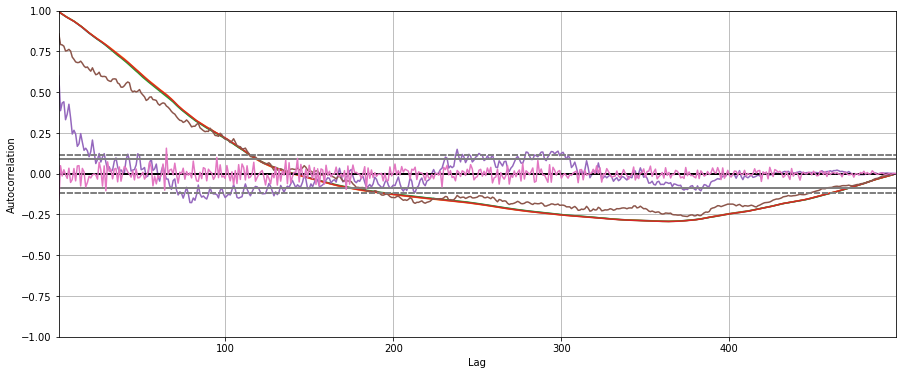

In [13]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(15,6))

# Creating Autocorrelation plot
for variable in df.columns:
    print("Variable: " + str(variable))
    ax = autocorrelation_plot(df[variable],)

In [17]:
# Get feature from dates
# df['year'] = df.index.year
#df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear
#df['is_month_start'] = (df.index.is_month_start).astype(int)
#df['is_month_end'] = (df.index.is_month_end).astype(int)

In [18]:
df.sample()

,open,high,low,close,volume,number_of_trades,y_temp,day,weekday
open_time,,,,,,,,,
2021-01-29,33368.18,38531.9,31915.4,34252.2,231827.005626,4403349.0,1,29,4


In [19]:
df.head()

,open,high,low,close,volume,number_of_trades,y_temp,day,weekday
open_time,,,,,,,,,
2019-12-20,7151.31,7220.00,7079.50,7187.83,32132.069205,312766.0,1,20,4
2019-12-21,7188.01,7190.58,7105.00,7132.75,19467.174028,212162.0,0,21,5
2019-12-22,7131.59,7518.54,7122.47,7501.44,39137.455150,356612.0,1,22,6
2019-12-23,7500.71,7695.38,7265.84,7317.09,68051.997203,530669.0,0,23,0
2019-12-24,7317.30,7436.68,7157.04,7255.77,43629.494188,384678.0,0,24,1


In [20]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
#values_ma = [5,15,30]
#
#for i in values_ma:
#    df["ma_close_" + str(i)] = df["close"].rolling(window=i).mean()
#    df["ma_volume_" + str(i)] = df["volume"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["close"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['close']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['close'].rolling(window=i).mean() + (df['close'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['close'].rolling(window=i).mean() - (df['close'].rolling(window=i).std()  * 2)

# Rate of change
values_rc = [5,15,30]
for i in values_rc:
    df["rc_" + str(i)] = df["close"].pct_change(periods = i)
    
# Stochastic Oscillators
#values_so = [5,15,30]
#for i in values_so:
#    lowest = df["low"].rolling(window = i).min()
#    high = df["high"].rolling(window = i).max()
#    df["so_" + str(i)] = ((df['close'] -lowest)/(high - lowest))*100
#    df["so_%D" + str(i)] = df["so_" + str(i)].rolling(window = i).mean()

In [21]:
df["y"] = df["y_temp"].shift(-1)
df[["y","y_temp"]].tail()

,y,y_temp
open_time,,
2021-04-27,0.0,1
2021-04-28,0.0,0
2021-04-29,1.0,0
2021-04-30,1.0,1
2021-05-01,NaN,1


In [22]:
past_t = 7 # Es hiperparametro del modelo
minus = 7

In [23]:
list_shift = list(range(1, minus))

for i in list_shift: 
    df["close_minus" + str(i)] = df["close"].shift(i)
    df["high_minus" + str(i)] = df["high"].shift(i)
    df["low_minus" + str(i)] = df["low"].shift(i)
    df["open_minus" + str(i)] = df["open"].shift(i)
    df["volume_minus" + str(i)] = df["volume"].shift(i)
    df["number_of_trades" + str(i)] = df["number_of_trades"].shift(i)
    df["y_temp_minus" + str(i)] = df["y_temp"].shift(i)

In [24]:
df.sample()

,open,high,low,close,volume,number_of_trades,y_temp,day,weekday,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,y,close_minus1,high_minus1,low_minus1,open_minus1,volume_minus1,number_of_trades1,y_temp_minus1,close_minus2,high_minus2,low_minus2,open_minus2,volume_minus2,number_of_trades2,y_temp_minus2,close_minus3,high_minus3,low_minus3,open_minus3,volume_minus3,number_of_trades3,y_temp_minus3,close_minus4,high_minus4,low_minus4,open_minus4,volume_minus4,number_of_trades4,y_temp_minus4,close_minus5,high_minus5,low_minus5,open_minus5,volume_minus5,number_of_trades5,y_temp_minus5,close_minus6,high_minus6,low_minus6,open_minus6,volume_minus6,number_of_trades6,y_temp_minus6
open_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-10,40088.22,41350.0,35111.11,38150.02,118209.544503,2628050.0,0,10,6,38177.61182,33758.951561,29404.692056,71.390063,81.63779,79.825769,42098.805943,35910.270057,43464.047995,27630.152005,42327.587542,19271.897458,0.123727,0.439983,1.115153,0.0,40088.22,41380.0,38720.0,40586.96,75785.979675,1998156.0,0.0,40582.81,41950.0,36500.0,39432.48,139789.957499,2925632.0,1.0,39432.28,40365.0,36300.0,36769.36,132825.700437,2814686.0,1.0,36769.36,36939.21,33288.0,33949.53,127139.20131,2591783.0,1.0,33949.53,34360.0,29900.0,31989.75,116049.997038,2526851.0,1.0,31988.71,33600.0,28130.0,33000.05,140899.88569,2642408.0,0.0


In [25]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (499, 67)
Shape: (468, 67)


In [26]:
X = df.drop(columns=["y"]).copy()
y = df["y"].copy().astype(int)

In [27]:
from catboost import CatBoostClassifier

parameters_catboost = {'depth' : [2,4,6],
                       'learning_rate' : [0.01],
                       'iterations' : [1000] }

modelo_catboost = CatBoostClassifier(loss_function='Logloss', # Funcion minimizadora del modelo https://catboost.ai/docs/concepts/loss-functions-regression.html
                                     verbose = 0,
                                     task_type = "CPU" #GPU
                                    )

In [36]:
from sklearn.model_selection import GridSearchCV

grid_catboost = GridSearchCV(estimator = modelo_catboost,
                             param_grid = parameters_catboost,
                             scoring = "accuracy", # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                             #return_train_score = True,
                             cv = 2,
                             n_jobs = -1,
                             verbose = 0              
                            )

In [37]:
y_real = pd.DataFrame(list(y.iloc[past_t:len(y)]), columns = ["y_real"], index = y.iloc[past_t:len(y)].index)
y_pred = pd.DataFrame([999] * (len(y)-past_t), columns = ["y_pred"], index = y.iloc[past_t:len(y)].index, dtype = 'int')
y_pred_p0 = pd.DataFrame([999] * (len(y)-past_t), columns = ["y_pred_p0"], index = y.iloc[past_t:len(y)].index, dtype = 'float')
y_pred_p1 = pd.DataFrame([999] * (len(y)-past_t), columns = ["y_pred_p1"], index = y.iloc[past_t:len(y)].index, dtype = 'float')

comparacion = pd.concat([y_real, y_pred, y_pred_p0, y_pred_p1], axis =1).copy()
comparacion.dtypes

y_real         int64
y_pred         int32
y_pred_p0    float64
y_pred_p1    float64
dtype: object

In [38]:
X.columns

Index(['open', 'high', 'low', 'close', 'volume', 'number_of_trades', 'y_temp',
       'day', 'weekday', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7',
       'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5',
       'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20',
       'bollinger_lower_20', 'rc_5', 'rc_15', 'rc_30', 'close_minus1',
       'high_minus1', 'low_minus1', 'open_minus1', 'volume_minus1',
       'number_of_trades1', 'y_temp_minus1', 'close_minus2', 'high_minus2',
       'low_minus2', 'open_minus2', 'volume_minus2', 'number_of_trades2',
       'y_temp_minus2', 'close_minus3', 'high_minus3', 'low_minus3',
       'open_minus3', 'volume_minus3', 'number_of_trades3', 'y_temp_minus3',
       'close_minus4', 'high_minus4', 'low_minus4', 'open_minus4',
       'volume_minus4', 'number_of_trades4', 'y_temp_minus4', 'close_minus5',
       'high_minus5', 'low_minus5', 'open_minus5', 'volume_minus5',
       'number_of_trades5', 'y_temp_minus5', 'close_minu

In [39]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

tope = len(df)-past_t
df_imp= []
for i in range(0, tope):
    # Train
    X_train = X.iloc[i:i+past_t]
    X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
    y_train = y.iloc[i:i+past_t]
    # Test
    X_test = X.iloc[i+past_t]
    X_test_ss = pd.DataFrame(ss.transform(np.array(X_test).reshape(1, -1)), columns = X_test.index)
    #X_test = ss.transform(X_test)
    y_test = y.iloc[i+past_t]
    # Train Close
    grid_catboost.fit(X_train_ss, y_train)
    pred = grid_catboost.best_estimator_.predict(X_test_ss)
    prob = grid_catboost.best_estimator_.predict_proba(X_test_ss)
    comparacion.at[ y.iloc[past_t:len(y)].index[i] , 'y_pred'] = pred[0]
    comparacion.at[ y.iloc[past_t:len(y)].index[i] , 'y_pred_p0'] = prob[0][0]
    comparacion.at[ y.iloc[past_t:len(y)].index[i] , 'y_pred_p1'] = prob[0][1]
    fea_imp = pd.DataFrame({'imp': grid_catboost.best_estimator_.feature_importances_, 'col': X_train_ss.columns})
    df_imp.append(fea_imp)
    print("Iteration: " + str(i+1) + "/" + str(tope) + " | Date " + str(X_test.name) + " | RealValue " + str(y_test) + " | Prediccion " + str(pred[0]) + "| Prob_0: " + str(prob[0][0]) + "| Prob_1: " + str(prob[0][1]), end='\r')   

C:\Users\AldoFranco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\AldoFranco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


C:\Users\AldoFranco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\AldoFranco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


KeyboardInterrupt: 

(35670, 2)
(87, 2)


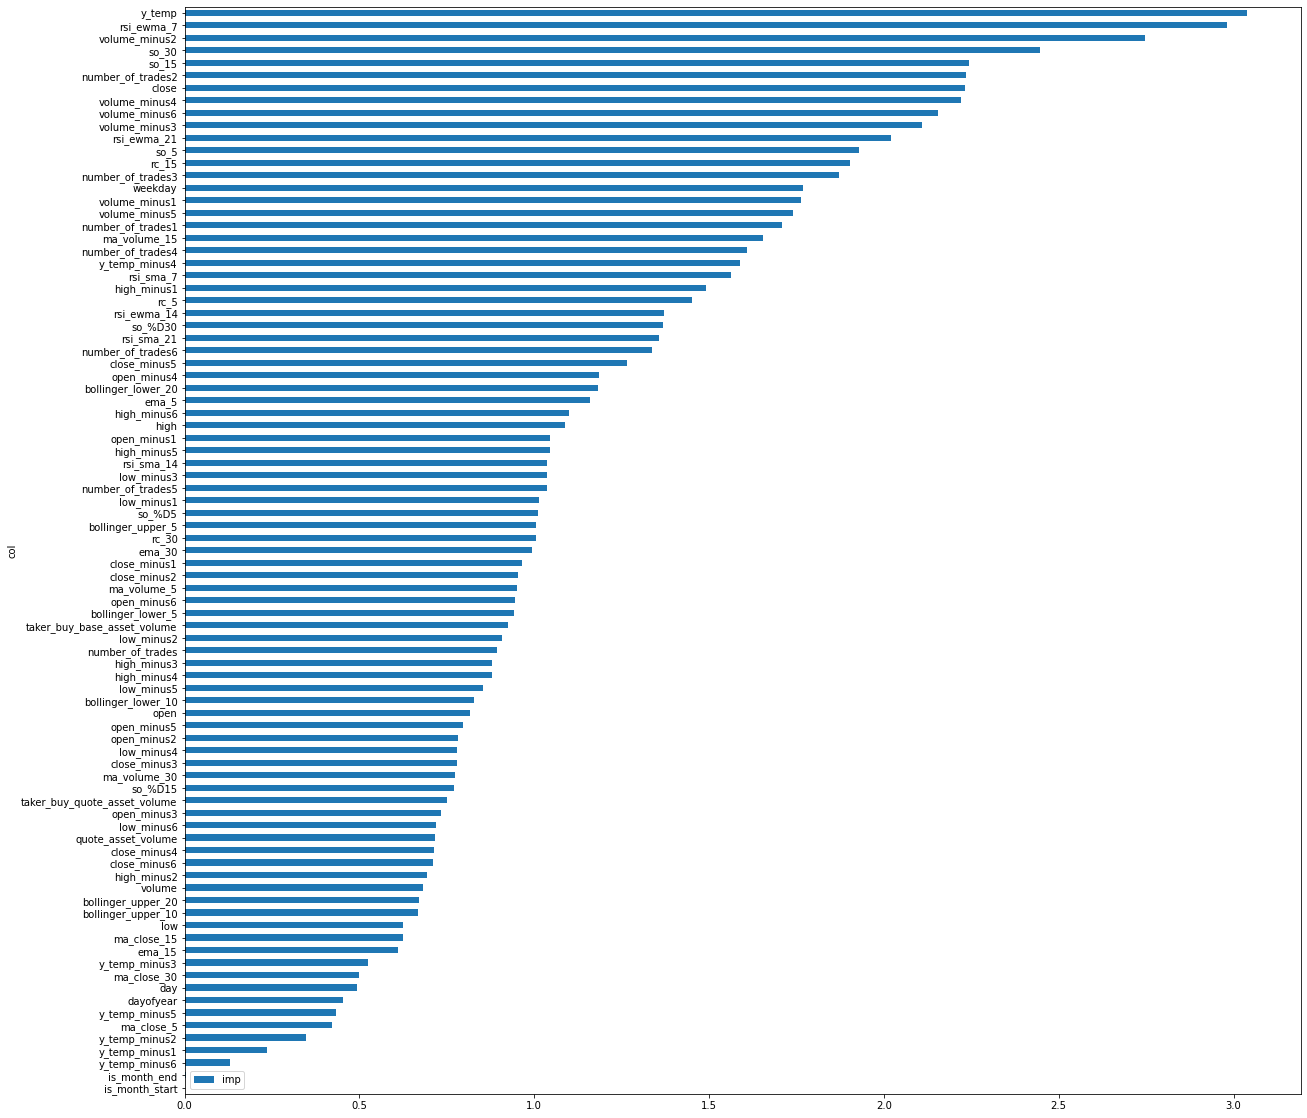

In [192]:
# Variables TOP 
fea_imp = pd.concat(df_imp)
print(fea_imp.shape)
fea_imp = fea_imp.groupby(["col"], as_index =  False).agg({"imp" : 'mean'})
print(fea_imp.shape)
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])#.iloc[-20:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 20))

In [193]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true = comparacion["y_real"], y_pred = comparacion["y_pred"])

0.4658536585365854

In [77]:
comparacion.dtypes

y_real         int64
y_pred       float64
y_pred_p0    float64
y_pred_p1    float64
dtype: object

In [194]:
comparacion.head()

,y_real,y_pred,y_pred_p0,y_pred_p1
open_time,,,,
2020-03-17,1,0,0.707591,0.292409
2020-03-18,1,1,0.196126,0.803874
2020-03-19,1,1,0.079819,0.920181
2020-03-20,0,1,0.069348,0.930652
2020-03-21,0,0,0.914989,0.085011


In [225]:
rango = np.arange(0,100)/100

rango

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [231]:
y_pred_temp = comparacion["y_pred_p1"] > 0.99
y_pred_temp.head()

open_time
2020-03-17    False
2020-03-18    False
2020-03-19    False
2020-03-20    False
2020-03-21    False
Name: y_pred_p1, dtype: bool

In [232]:
y_pred_temp.astype(int).head()

open_time
2020-03-17    0
2020-03-18    0
2020-03-19    0
2020-03-20    0
2020-03-21    0
Name: y_pred_p1, dtype: int32

In [234]:
from sklearn import metrics

acc = []
for i in rango:
    y_pred_temp = comparacion["y_pred"] > i
    y_pred_temp = y_pred_temp.astype(int)
    acc_temp = metrics.accuracy_score(y_true = comparacion["y_real"], y_pred = y_pred_temp)
    acc.append(acc_temp)

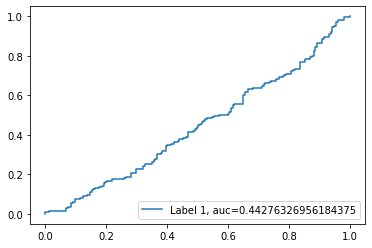

In [240]:
y_pred_proba = comparacion[["y_pred_p1"]].values
fpr, tpr, _ = metrics.roc_curve(comparacion[["y_real"]].values,  y_pred_proba)
auc = metrics.roc_auc_score(comparacion[["y_real"]].values, y_pred_proba)
plt.plot(fpr,tpr,label="Label 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()